# Using Spectral Weights

This guide shows how to weight Scans and spectra during averaging and how to find out what weights were used in the process.


You can find a copy of this tutorial as a Jupyter notebook [here](https://github.com/GreenBankObservatory/dysh/blob/main/notebooks/examples/using_spectral_weights.ipynb) or download it by right clicking  <a href="https://raw.githubusercontent.com/GreenBankObservatory/dysh/refs/heads/main/notebooks/examples/using_spectral_weights.ipynb" download>here</a> and selecting "Save Link As".

## Loading Modules
We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) matplotlib backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on jupyter lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for the data reduction.
from dysh.fits.gbtfitsload import GBTFITSLoad

# This module is used for custom plotting.
import matplotlib.pyplot as plt

# These modules are only used to download the data.
from pathlib import Path
from dysh.util.download import from_url
import numpy as np
import astropy.units as u

## Data Retrieval

Download the example SDFITS data, if necessary.

In [2]:
url = "http://www.gb.nrao.edu/dysh/example_data/positionswitch/data/AGBT05B_047_01/AGBT05B_047_01.raw.acs/AGBT05B_047_01.raw.acs.fits"
savepath = Path.cwd() / "data"
savepath.mkdir(exist_ok=True) # Create the data directory if it does not exist.
filename = from_url(url, savepath)

## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [3]:
sdf = GBTFITSLoad(filename)
sdf.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


### Position Switched Calibration
We calibrate several scans at once for NGC5291.  This results in a ScanBlock with 4 scans, each with 11 integrations. The default weights are unity, with one weight value per integration.


In [4]:
pssb = sdf.getps(object='NGC5291',ifnum=0,plnum=1,fdnum=0)
print(f"Number of scans: {len(pssb)}, Number of integrations per scan: {[len(k) for k in pssb]}")
print(f"Scan weights: {pssb.weights}")

Number of scans: 4, Number of integrations per scan: [11, 11, 11, 11]
Scan weights: [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]


## Applying weights when averaging Scans
When averaging scans to create a final spectrum, you can choose from dysh's two options ('tsys' or None) or supply your own weight array.

### 1. System temperature weighting
The default for `timeaverage()` is 'tsys' which calculates and applies system temperature weighting to each integration: 

$w = t_{exp} \times \delta\nu/T_{sys}^2$,

where $t_{exp}$ is the integraton exposure time, $\delta\nu$ is the channel width, and $T_{sys}$ is the system temperature.  You can check what those weights will be with `tsys_weight`. 

In [5]:
pssb.tsys_weight

array([array([20.02238592, 19.23775753, 19.89469281, 19.13748516, 19.43619207,
              19.24989036, 19.94781504, 19.81766121, 19.90398672, 19.86791497,
              19.1754635 ])                                                   ,
       array([18.94476267, 19.78439063, 19.85434244, 19.90054628, 19.95968097,
              19.08878802, 18.97575899, 18.5760123 , 19.76114768, 19.71441725,
              19.70968407])                                                   ,
       array([18.77161334, 19.62257845, 19.70200273, 19.68613794, 19.65882906,
              19.85660591, 19.57284449, 19.60902436, 18.74157248, 18.6538321 ,
              18.75593527])                                                   ,
       array([18.44256036, 18.36839774, 18.34613799, 18.39603826, 17.95338427,
              19.04965151, 19.09771163, 19.18475276, 19.09809603, 19.09126971,
              18.34217249])                                                   ],
      dtype=object)

(Note this is an array of arrays rather than a multidimensional array because different Scans may have differing numbers of integrations).

`timeaverage()` with the default arguments will use these weights.  The final spectral weight is the sum of all weights.

final weights=[847.9619254640448 847.9619254640448 847.9619254640448 ...
 847.9619254640448 847.9619254640448 847.9619254640448]


{'mean': <Quantity 0.00493475 K>,
 'median': <Quantity 0.00348282 K>,
 'rms': <Quantity 0.05926608 K>,
 'min': <Quantity -1.74795386 K>,
 'max': <Quantity 0.76657301 K>,
 'npt': 32768,
 'nan': 0}

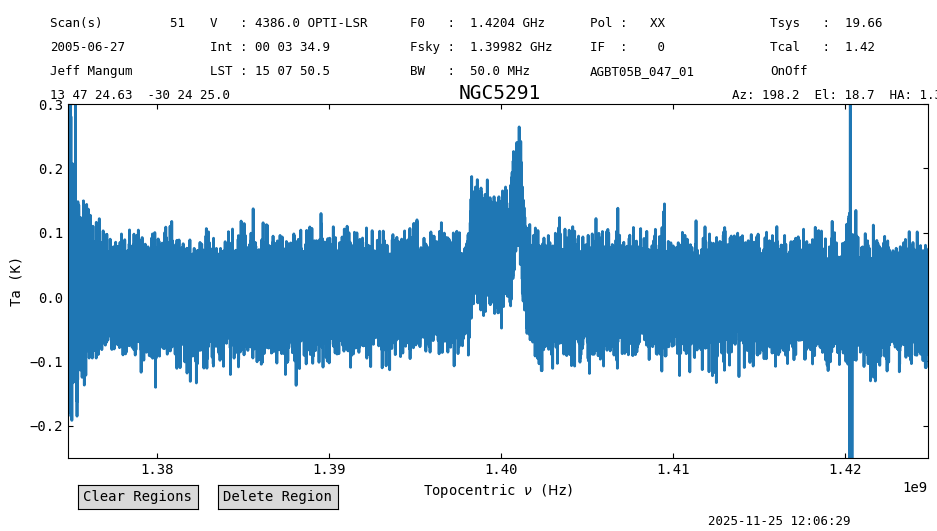

In [6]:
ta = pssb.timeaverage()  # default is weights='tsys'
exclude_regions=[(1.37*u.GHz,1.38*u.GHz),(1.395*u.GHz,1.405*u.GHz),(1.42*u.GHz,1.43*u.GHz)]
ta.baseline(degree=1, remove=True, exclude=exclude_regions)
ta.plot(ymin=-0.25,ymax=0.3)
print(f"final weights={ta.weights}")
ta.stats()

### 2. Equal weighting
Supplying `weights=None` will weight all integrations the same.  In this case, the result is not much different thatn `tsys`, because the $T_{sys}$ weights were already pretty uniform.

final weights=[4.0 4.0 4.0 ... 4.0 4.0 4.0]


{'mean': <Quantity 0.00493513 K>,
 'median': <Quantity 0.00344473 K>,
 'rms': <Quantity 0.05928395 K>,
 'min': <Quantity -1.74943677 K>,
 'max': <Quantity 0.76626611 K>,
 'npt': 32768,
 'nan': 0}

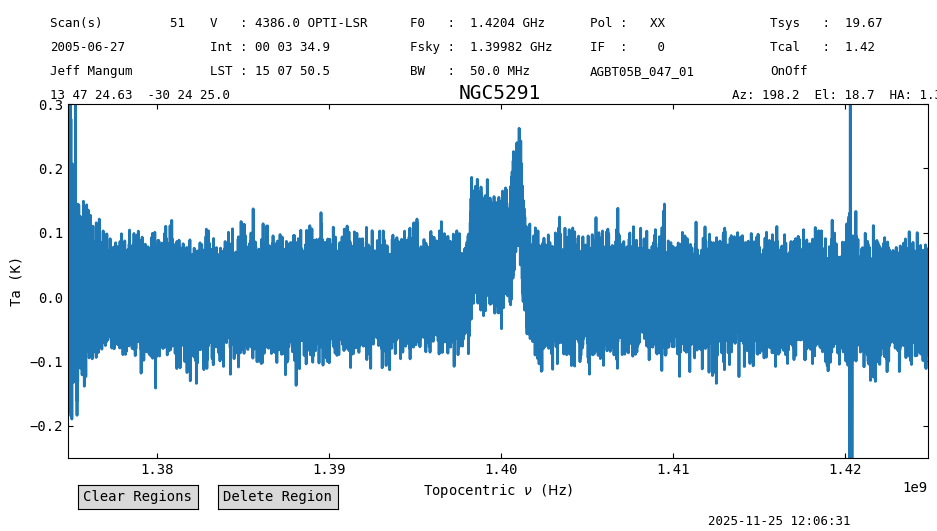

In [7]:
ta2 = pssb.timeaverage(weights=None)  
ta2.baseline(degree=1,remove=True,exclude=exclude_regions)
ta2.plot(ymin=-0.25,ymax=0.3)
print(f"final weights={ta2.weights}")
ta2.stats()

### 3. User-supplied weights
You can supply a numpy array of weights to apply.  For `ScanBlock.timeavearage()` the weights must have shape `(Nint,)` or `(Nint,nchan)` where `Nint` is the number of integrations in the ScanBlock and `nchan` is the number of channels in each Scan.  

#### 3a.  Number of weights equal to number of integrations.
We create a slightly silly example, that weights later integrations more.

final weights=[990.0 990.0 990.0 ... 990.0 990.0 990.0]


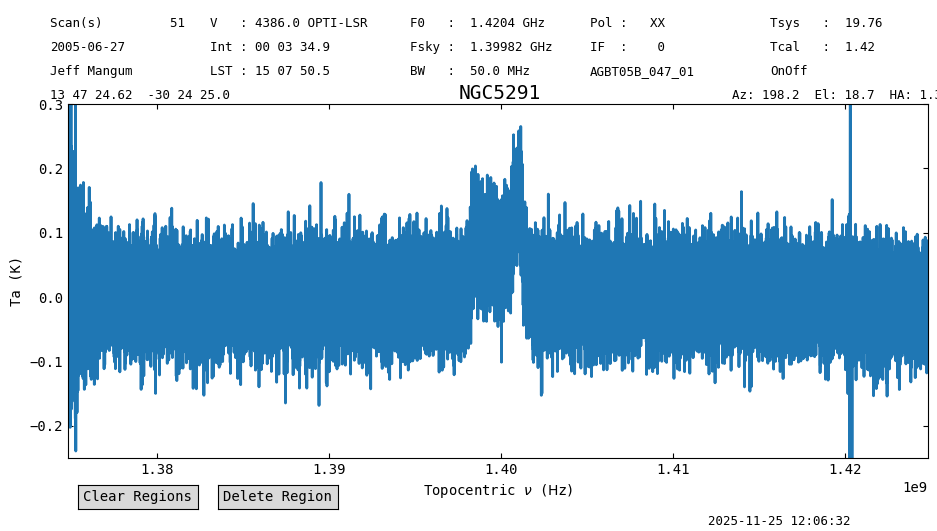

In [8]:
w = np.arange(1,pssb.nint+1,dtype=float)
ta3 = pssb.timeaverage(weights=w)
ta3.baseline(degree=1,remove=True,exclude=exclude_regions)
ta3.plot(ymin=-0.25,ymax=0.3)
print(f"final weights={ta3.weights}")

#### 3b.  Weights array with shape `(nint,nchan)`
Supposed you had a channel-based $T_{sys}$ for each integration and wanted to calculate and apply system temperature weights. This can be accomplished by giving a weights array to `ScanBlock.timeaverage()`.

First we fake a `tsys` array of the correct shape.  Then we calculate system temperate weights using the mean exposure time and mean channel width of the Scans.

In [9]:
from dysh.spectra import tsys_weight
tsys=30+np.random.rand(pssb.nint,pssb.nchan)*15.0  # a fake system temperature array in the 30-45K range
dt = np.mean(np.mean(pssb.exposure))
df = np.mean(np.mean(pssb.delta_freq))
w=tsys_weight(dt,df,tsys)
print(f"{tsys=}")
print(f"Weights array shape: {w.shape}")

tsys=array([[31.08952701, 39.51063382, 42.8900714 , ..., 44.89775497,
        38.85003523, 43.40258314],
       [31.15582641, 36.16187461, 41.19404163, ..., 37.0141477 ,
        42.41072029, 34.83841092],
       [33.17975664, 32.48185711, 38.77091784, ..., 41.10615408,
        30.89194281, 34.70843742],
       ...,
       [40.95189872, 31.66992492, 35.64647915, ..., 44.17253345,
        32.2674015 , 44.54838625],
       [44.30556966, 33.08229241, 33.36999445, ..., 35.25134792,
        32.65384495, 33.25826165],
       [38.21540956, 42.92703594, 36.97584951, ..., 41.38633222,
        32.14470551, 30.81101858]])
Weights array shape: (44, 32768)


final weights=[237.44894638509527 244.3544730805292 237.67430203040954 ...
 235.16583693518166 254.20225473697647 240.98519101813457]


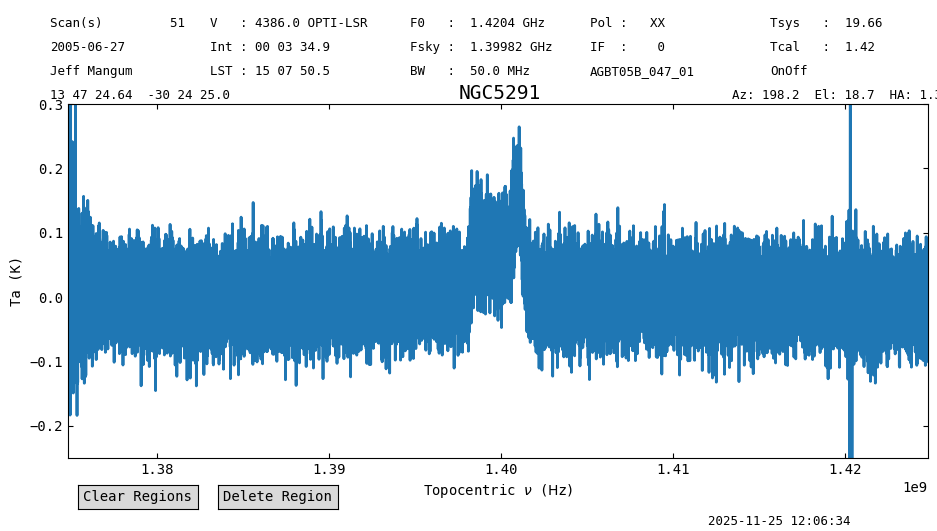

In [10]:
ta4 = pssb.timeaverage(weights=w)
ta4.baseline(degree=1,remove=True,exclude=exclude_regions)
ta4.plot(ymin=-0.25,ymax=0.3)
print(f"final weights={ta4.weights}")

### 4. Averaging lists of spectra with pre-computed weights
The method `average_spectra` can compute weighted averages in 3 ways.  The first two are the usual `weights='tsys'` and `weights=None` options.  The third option, `weights='spectral'` will average the spectra using the values in each of their `weights` array. 

In [11]:
from dysh.spectra import average_spectra 
sp = average_spectra([ta,ta2,ta3,ta3],weights='spectral')

final weights=[2831.9619254640447 2831.9619254640447 2831.9619254640447 ...
 2831.9619254640447 2831.9619254640447 2831.9619254640447]


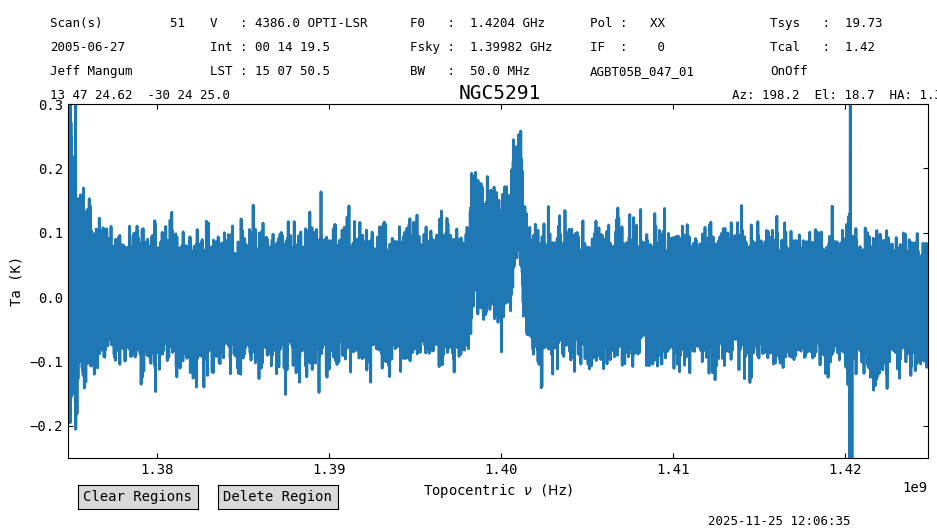

In [12]:
sp.plot(ymin=-0.25,ymax=0.3)
print(f"final weights={sp.weights}")